In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tabulate import tabulate

# Congruential Random Number Generator

A congruential random number generator constructs a sequence of pseudorandom numbers using a discontinuous piecewise linear equation. The simplest form of a congruential random number generator can be defined as:

$x_i = (cx_{i-1})\mod p$

where $c$, $p$, and a seed value $x_0$ are chosen integers. The iteraton generates random numbers $x_i$ in the interval $[0, p-1]$. To transform this into a normalized sequence $z_i$ in $[0, 1)$, we can divide by $p$:

$0 \le z_i = \frac{x_i}{p} \lt 1$

In [2]:
def congruential_rngs(c, p, x0, num_iter=10000):
    rngs = [x0]
    for i in range(1, num_iter):
        rngs.append(c * rngs[i-1] % p)
    return rngs

In [3]:
c = 3
p = 31
x0 = 1
rngs = congruential_rngs(c, p, x0)
print(rngs[:30])

[1, 3, 9, 27, 19, 26, 16, 17, 20, 29, 25, 13, 8, 24, 10, 30, 28, 22, 4, 12, 5, 15, 14, 11, 2, 6, 18, 23, 7, 21]


## How can we evaluate how "random" these pseudorandom numbers are?

### Frequencies

Do some numbers occur more often than others?

In [18]:
def frequencies(rngs):
    values, counts = np.unique(rngs, return_counts=True)
    print(tabulate(sorted(zip(values,counts)), headers=["Number", "Count"]))

In [19]:
frequencies(rngs)

  Number    Count
--------  -------
       1      334
       2      333
       3      334
       4      333
       5      333
       6      333
       7      333
       8      333
       9      334
      10      333
      11      333
      12      333
      13      333
      14      333
      15      333
      16      334
      17      334
      18      333
      19      334
      20      334
      21      333
      22      333
      23      333
      24      333
      25      333
      26      334
      27      334
      28      333
      29      334
      30      333


In [20]:
def histogram(rngs):
    plt.hist(rngs, bins=max(rngs))
    plt.xlabel("Pseudorandom Number")
    plt.ylabel("Frequency")
    plt.show()

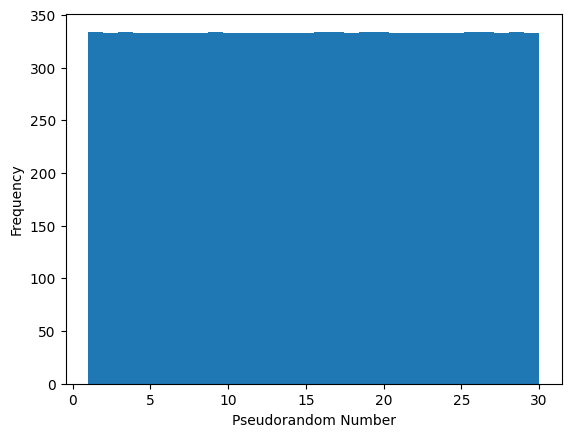

In [21]:
histogram(rngs)

The frequencies of the numbers geenrated by this RNG are well distributed.

### Sequences: Square Test and Cube Test

Plotting sequences of consecutive pseudorandom numbers may reveal patterns, indicating the existence of internal correlations.

In [14]:
def square_test(rngs):
    plt.scatter(rngs[:-1], rngs[1:])
    plt.title("Square Test: Pairs of Consecutive Pseudorandom Numbers")
    plt.xlabel("$x_i$: First Pseudorandom Number")
    plt.ylabel("$x_{i+1}$: Next Pseudorandom Number")
    plt.show()

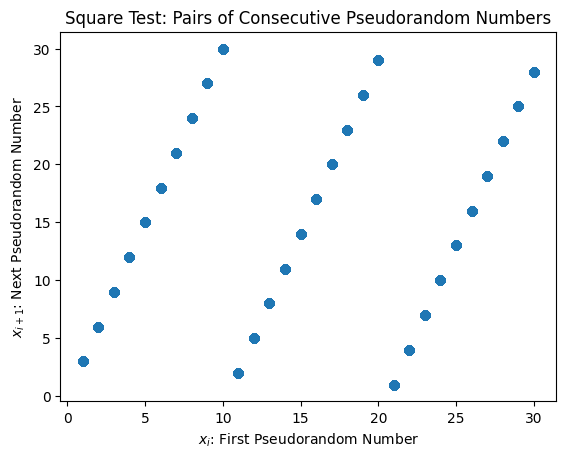

In [15]:
square_test(rngs)

A pattern is evident! The numbers are not randomly distributed, but appear along "planes".

In [16]:
def cube_test(rngs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(rngs[:-2], rngs[1:-1], rngs[2:])
    
    plt.title("Cube Test: Triplets of Consecutive Pseudorandom Numbers")
    ax.set_xlabel("$x_i$: First Number")
    ax.set_ylabel("$x_{i+1}$: Second Number")
    ax.set_zlabel("$x_{i+2}$: Third Number")
    plt.show()

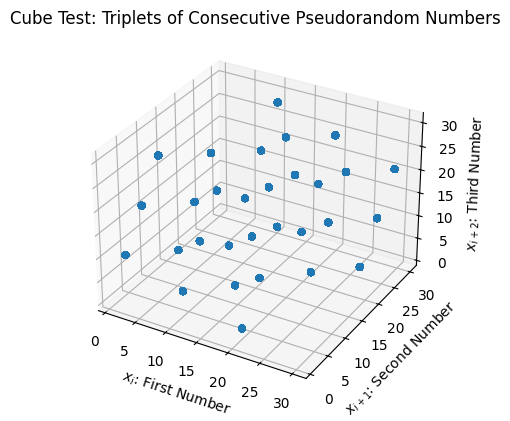

In [17]:
cube_test(rngs)

The pattern in the consecutive triplets also appears to form "planes", perhaps across the $x_{i+2}$ axis, though it is arguably less obvious compared to the consecutive pairs. The fact that (num_iter = 10,000) - 2 = 9,998 triplets reduces to only the number of points seen here (30 -- the number of points in the set of pseudorandomly generated numbers) is itself an indication of a lack of true randomness. Truly random sequences, in which the next number in the sequence is entirely uncoupled from the previous, could be distributed over $x * x$ points in the square test or $x * x * x$ points in the cube test.

## Evaluate another congruential RNG

In [28]:
c = 5
p = 29
#x0 = 1
rngs2 = congruential_rngs(c, p, x0, 100000)
print(rngs2[:30])

[1, 5, 25, 9, 16, 22, 23, 28, 24, 4, 20, 13, 7, 6, 1, 5, 25, 9, 16, 22, 23, 28, 24, 4, 20, 13, 7, 6, 1, 5]


  Number    Count
--------  -------
       1     7143
       4     7143
       5     7143
       6     7142
       7     7142
       9     7143
      13     7143
      16     7143
      20     7143
      22     7143
      23     7143
      24     7143
      25     7143
      28     7143


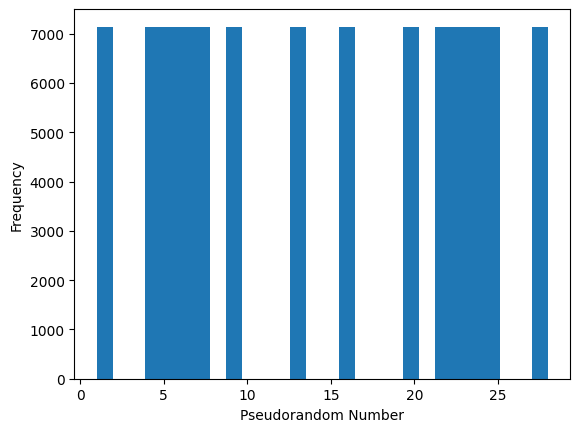

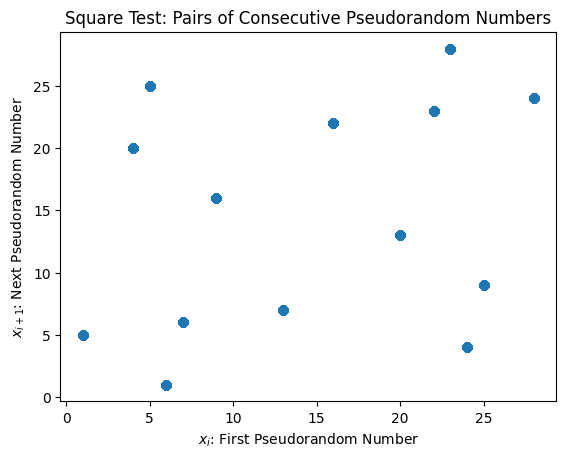

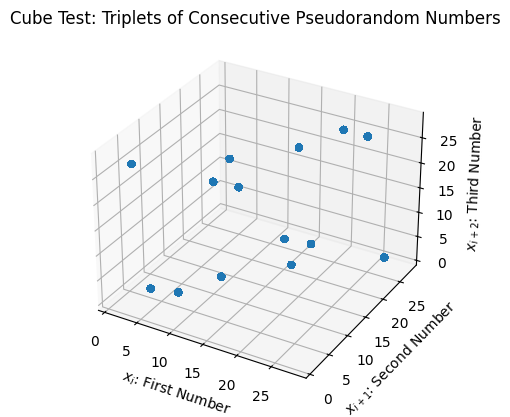

In [29]:
frequencies(rngs2)
histogram(rngs2)
square_test(rngs2)
cube_test(rngs2)

This RNG appears "more random" according to the scatter plot, but skips many numbers entirely, and the number of observed pairs or triplets is very small compared to the number of possible pairs or triplets.